#Installing Detectron2 dependencies

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [0]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Let's try COCO KeyPoint Segmentation on a TikTok Video

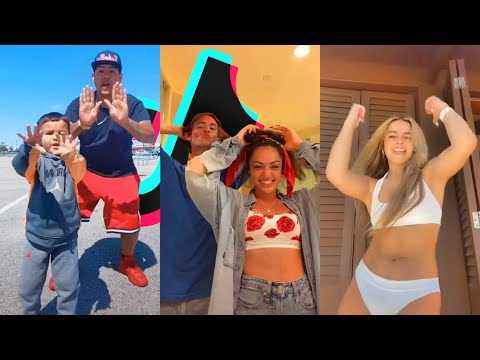

In [4]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("S5zttDDYGJo", width=500)
display(video)

In [0]:
# Install dependencies, download the video, and crop 15 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=S5zttDDYGJo -f 22 -o original_clip.mp4
!ffmpeg -i original_clip.mp4 -t 00:00:15 -c:v copy cropped_clip.mp4

In [0]:
!git clone https://github.com/thatguySid/detectron2.git
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml --video-input cropped_clip.mp4 --confidence-threshold 0.6 --output output_clip.mp4 \
  --opts MODEL.WEIGHTS detectron2://COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl

In [0]:
from google.colab import files
files.download('output_clip.mp4')

# Getting Keypoint Instances from a Video

In [0]:
import cv2
import numpy as np
import os, sys

frames = []
frame_count = 0
# Colab GPU fits 3 images at once
batch_size = 3

# Setup directory
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")

# Start video capture
capture = cv2.VideoCapture('output_clip.mp4')
try:
  if not os.path.exists(VIDEO_SAVE_DIR):
    os.makedirs(VIDEO_SAVE_DIR)
  if (capture.isOpened()== False): 
    print("Error opening video stream or file")
except OSError:
  print ('Error: Creating directory of data')

capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

# Set the model configs
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Processing the video in batches
while True:
  ret, frame = capture.read()
  if not ret:
    break

  frame_count += 1
  frames.append(frame)
  print('frame_count :{0}'.format(frame_count))

  outputs = predictor(frame)

  if len(frames) == batch_size:
    for i in range (1, batch_size+1):
      v = Visualizer(frame, MetadataCatalog.get("coco_2017_val"), scale=1.5)
      v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      v = v.get_image()[:, :, ::-1]

      name = '{0}.jpg'.format(frame_count + i - batch_size)
      name = os.path.join(VIDEO_SAVE_DIR, name)
      cv2.imwrite(name, frame)
      print('writing to file:{0}'.format(name))

    # Clear the frames array to start the next batch
    frames=[]
 
# When everything done, release the video capture
capture.release()
cv2.destroyAllWindows()
print('Task Finished')

In [61]:
print(outputs)

{'instances': Instances(num_instances=3, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[440.8087, 309.0648, 674.5001, 709.5408],
        [577.5407, 368.3949, 843.2260, 680.4802],
        [681.0983, 367.8577, 841.3871, 605.0357]], device='cuda:0')), scores: tensor([0.9852, 0.8692, 0.8270], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0'), pred_keypoints: tensor([[[5.8782e+02, 3.5266e+02, 1.1312e+00],
         [6.0027e+02, 3.4308e+02, 7.8145e-01],
         [5.7537e+02, 3.4499e+02, 1.3562e+00],
         [6.2422e+02, 3.5841e+02, 7.6193e-01],
         [5.6580e+02, 3.6128e+02, 4.1837e-01],
         [6.5487e+02, 4.3601e+02, 1.9352e-01],
         [5.5047e+02, 4.3793e+02, 1.1234e-01],
         [5.8303e+02, 5.0882e+02, 3.2244e-01],
         [4.8726e+02, 4.6954e+02, 7.3767e-02],
         [5.4568e+02, 4.2930e+02, 3.0443e-01],
         [4.7960e+02, 4.3601e+02, 9.6767e-02],
         [5.6292e+02, 6.3050e+02, 1.0853e-02],
         [5.0258e+02, 6.6691e+02, 1.17